<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
# Lesson 16 - Time Series Modelling - Demo


---

If you have not yet upgraded to statsmodels 0.8.0, do that with 

```
pip install --upgrade --no-deps statsmodels
```

otherwise you might get warning messages.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

We will be using data made available by a German drugstore, Rossmann. This dataset contains the daily sales made at various drugstores over a 3-year period as well as whether there was a sale or holiday affecting the sales data.

[Kaggle Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales)

>Rossmann operates over 3,000 drug stores in 7 European countries. Currently, 
Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Data Dictionary

- **`Id`**: an Id that represents a (Store, Date) tuple within the test set
- **`Store`**: a unique Id for each store
- **`Sales`**: the turnover for any given day (this is what you are predicting)
- **`Customers`**: the number of customers on a given day
- **`Open`**: an indicator for whether the store was open: 0 = closed, 1 = open
- **`StateHoliday`**: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **`SchoolHoliday`**: indicates if the (Store, Date) was affected by the closure of public schools
- **`Promo`**: indicates whether a store is running a promo on that day.


In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time. Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day, week or month?

/Users/zoealdington/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/zoealdington/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


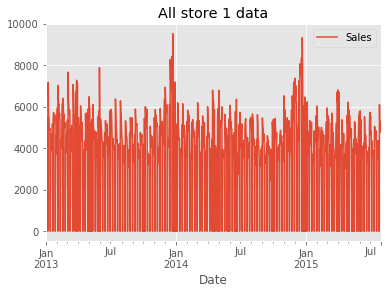

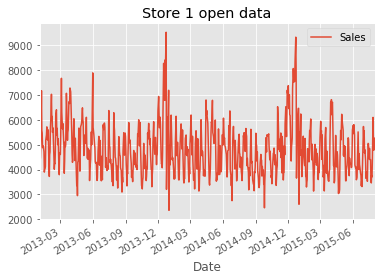

In [28]:
import numpy as np
import pandas as pd

# Load the data and set the DateTime index
data = pd.read_csv('rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]
store1_data.sort_index(inplace=True)
# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

# Plot the sales over time
store1_data[['Sales']].plot()
plt.title('All store 1 data')
plt.show()

# Plot the sales over time
store1_open_data[['Sales']].plot()
plt.title('Store 1 open data')
plt.show()

## Activity: Knowledge Check

1. Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. 
1. Will we be able to use a predictive model - particularly an autoregressive one?

In [29]:
print(store1_data.Sales.autocorr(lag=1))
print(store1_data.Sales.autocorr(lag=2))
print(store1_data.Sales.autocorr(lag=7))

-0.127325143391
-0.0347871557079
0.630719243284


In [30]:
print(store1_open_data.Sales.autocorr(lag=1))
print(store1_open_data.Sales.autocorr(lag=2))
print(store1_open_data.Sales.autocorr(lag=7))

0.682690824228
0.481217266146
-0.0571198713659


We see decent minimal correlation in lag-1 and lag-2, implying an AR model can be useful.

An easier way to diagnose this may be to plot many autocorrelations at once.

Pandas and statsmodels both provide convenience plots for autocorrelations.

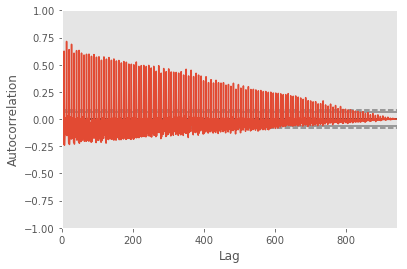

In [31]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(store1_data.Sales)
plt.show()

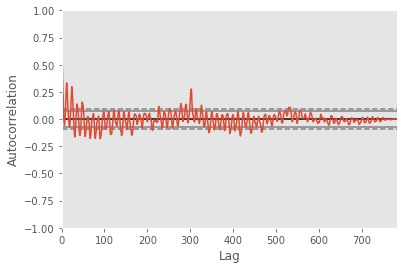

In [19]:
autocorrelation_plot(store1_open_data.Sales)
plt.show()

Both of these show a typical pattern of an autocorrelation plot, that it should decrease to 0 as lag increases.  However, it’s hard to observe exactly what the values are.


In this class, we will use statsmodels to code AR, MA, ARMA, and ARIMA models.

Statsmodels provides a nice summary utility to help us diagnose models. Statsmodels also has a better autocorrelation plot that allows us to look at fixed number of lag values.

/Users/zoealdington/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


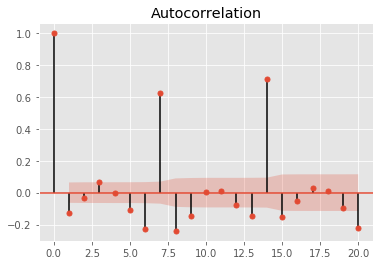

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_data.Sales, lags=20)
plt.show()

**Check**: What caused the spike at 7?

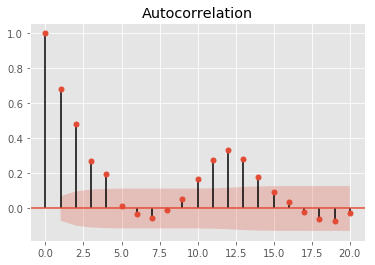

In [23]:
plot_acf(store1_open_data.Sales, lags=20) # only plot lags 1 to 20
plt.show()

Here we observe autocorrelation at 20 lag values.  1 and 2 are what we saw before.

This implies a significant impact based on the last few values.  An autoregressive model should be useful. We also see a larger spike at 7 (the seventh day in the week) for all days (open and closed), and at lag 12 when looking only at days when the store is open.

If we observed a handful of randomly distributed spikes, a moving average model would be useful.

We can expand the window to 45 days to see that the random spikes occur regularly every 7 days (all days) or every 12 days (open days).  What does this mean?

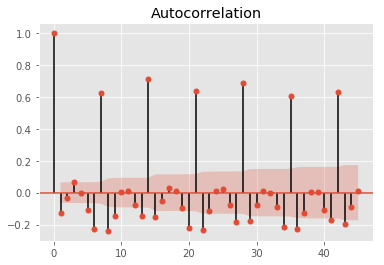

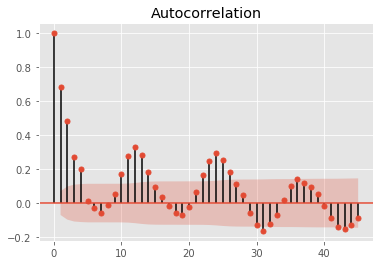

In [24]:
plot_acf(store1_data.Sales, lags=45)
plt.show()
plot_acf(store1_open_data.Sales, lags=45)
plt.show()

#### Demonstrating the pattern in promotional days

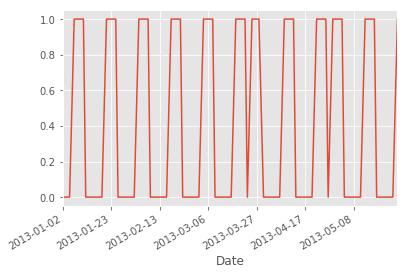

[4, 5, 6, 7, 8, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 40, 41, 42, 43, 44, 52, 53, 54, 55, 56, 64, 65, 66, 67, 68, 70, 71, 72, 73, 80, 81, 82, 83, 84, 92, 93, 94, 95, 96, 98, 99]


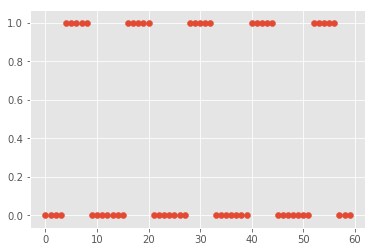

In [26]:
store1_open_data.Promo.iloc[:120].plot()
plt.show()

# print out which days correspond to promotional days 
print ([item[0] for item in zip(range(100),store1_open_data.Promo.values[:100]) if item[1]==1])

# create a plot indicating promotional and non-promotional days
promos = [item for item in zip(range(len(store1_open_data)),store1_open_data.Promo.values)]
limit = 60
plt.scatter([promo[0] for promo in promos[:limit]],[promo[1] for promo in promos[:limit]])
plt.show()

# ARMA Model

To explore AR, MA, and ARMA models, we will use `statsmodels.tsa.arima_model`. 

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and an `MA(q)` model. So if we want just an `AR(p)` model we use an `ARMA(p, 0)` model. 

In [34]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Sun, 19 Nov 2017   AIC                          12540.651
Time:                        18:44:05   BIC                          12554.633
Sample:                    01-02-2013   HQIC                         12546.029
                         - 07-31-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.8241     82.986     57.393      0.000    4600.174    4925.474
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4659           +0.0000j            1.4659            0.0000
-----------------------------------------------------------------------------
"""

By passing the (1, 0) in the second argument, we are fitting an ARMA model as ARMA(p=1, q=0). Remember, an ARMA(p, q) model is AR(p) + MA(q). This means that an ARMA(1, 0) is the same as an AR(1) model.

In this AR(1) model we learn an intercept value, or base sales values. Additionally, we learn a coefficient that tells us how to include the last sales values. In this case, we take the intercept of ~4700 and add in the previous months sales times 0.68.

Note the coefficient here approximately matches the lag 1 autocorrelation - implying the data is stationary.

We can learn an AR(2) model, which regresses each sales value on the last two, with the following:

In [35]:
model = ARMA(store1_sales_data, (2, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Sun, 19 Nov 2017   AIC                          12542.063
Time:                        18:44:09   BIC                          12560.705
Sample:                    01-02-2013   HQIC                         12549.233
                         - 07-31-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.5001     85.261     55.858      0.000    4595.391    4929.609
ar.L1.Sales     0.6634      0.036     18.537      0.000       0.593       0.734
ar.L2.Sales     0.0275      0.036      0.767      0.443      -0.043       0.098
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4235           +0.0000j            1.4235            0.0000
AR.2          -25.5904           +0.0000j           25.5904            0.5000
-----------------------------------------------------------------------------
"""

Here we learn two coefficients, which tell us the effect of the last two sales values on current sales. To make a sales prediction for a future month, we would combine the last two months of sales with the weights or coefficients learned.

While this model may be able to better model the series, it may be more difficult to interpret.

To start to diagnose the model, we want to look at the residuals.

Just like with other types of regression, we can compute the model residuals.

**Check:** 
- What are residuals? 
- In linear regression, what did we expect of residuals?

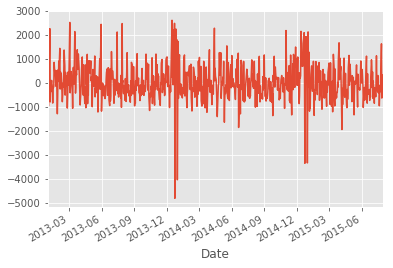

In [36]:
model.resid.plot()
plt.show()

Here we see large spikes at the end of each year, indicating that our model does not account for holiday spikes. Of course, our models are only related to the last few values in the time series, and don't take into account the longer seasonal pattern.

We can also plot the autocorrelations of the residuals. In an ideal model, these would all nearly be 0 and hopefully random.

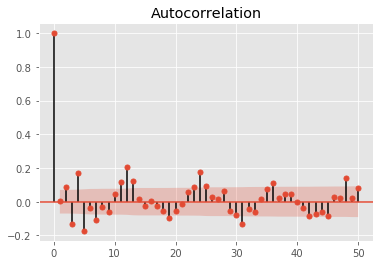

In [37]:
plot_acf(model.resid, lags=50)
plt.show()

This plot shows a problem: the errors are increasing and decreasing every week in a clear pattern. We may need to expand our model. 

To expand this AR model to an ARMA model, we can include the moving average component as well.

In [13]:
model = ARMA(store1_sales_data, (1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Mon, 10 Jul 2017   AIC                          12542.222
Time:                        16:16:41   BIC                          12560.865
Sample:                    01-02-2013   HQIC                         12549.392
                         - 07-31-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.5797     84.700     56.228      0.000    4596.570    4928.590
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654      0.514      -0.118       0.059
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4329           +0.0000j            1.4329            0.0000
MA.1           34.0042           +0.0000j           34.0042            0.0000
-----------------------------------------------------------------------------
"""

Now we learn two coefficients, one for the AR(1) component and one for the MA(1).

The AR coefficient represents dependency on the last value and the MA component represents any spikes independent of the last value.

The coefficients here are 0.69 for the AR component and -0.03 for the MA component.  

The AR coefficient is the same as before (decreasing values).

The MA component is fairly small (which we should have expected from the autocorrelation plots).

## ARIMA Models in Statsmodels
To train an ARIMA model in statsmodels, we can change the ARMA model to ARIMA and additionally provide the differencing parameter. To start, we can see that we can train an ARMA(1,1) model by training an ARIMA(1, 0, 1) model. In fact, this is the same as our previous model.

In [14]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (1, 0, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Mon, 10 Jul 2017   AIC                          12542.222
Time:                        16:16:41   BIC                          12560.865
Sample:                    01-02-2013   HQIC                         12549.392
                         - 07-31-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.5797     84.700     56.228      0.000    4596.570    4928.590
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654      0.514      -0.118       0.059
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4329           +0.0000j            1.4329            0.0000
MA.1           34.0042           +0.0000j           34.0042            0.0000
-----------------------------------------------------------------------------
"""

If we change the differencing parameter to 1, we can fit a true ARIMA(1, 1, 1) model to predict for the difference of the series.

In [15]:
model = ARIMA(store1_sales_data, (1, 1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6261.011
Method:                       css-mle   S.D. of innovations            738.632
Date:                Mon, 10 Jul 2017   AIC                          12530.022
Time:                        16:16:41   BIC                          12548.659
Sample:                    01-03-2013   HQIC                         12537.190
                         - 07-31-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5108      0.364     -1.405      0.160      -1.223       0.202
ar.L1.D.Sales     0.6801      0.026     25.801      0.000       0.628       0.732
ma.L1.D.Sales    -1.0000      0.004   -240.403      0.000      -1.008      -0.992
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4703           +0.0000j            1.4703            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Let's remove the MA component to see its impact.

In [16]:
model = ARIMA(store1_sales_data, (1, 1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Mon, 10 Jul 2017   AIC                          12633.233
Time:                        16:16:42   BIC                          12647.211
Sample:                    01-03-2013   HQIC                         12638.609
                         - 07-31-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1449     24.028     -0.006      0.995     -47.238      46.948
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000      -0.251      -0.112
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.5103           +0.0000j            5.5103            0.5000
-----------------------------------------------------------------------------
"""

We now have an AR(1) model on the differenced series with a coefficient of -0.18

## Activity: Knowledge Check
1. Does this model match the lag 1 autocorrelation of the differenced series?
2. Is the data stationary?

We can also plot it to see the difference.

Coefficient and lag 1 autocorrelation match. Note that this is generally true, but the variance is NOT constant.
It’s mostly the same throughout the series except around the holidays.

## Forecasting with ARIMA models
With our models, we can also plot future predictions and compare them with the true series. To compare our forecast with the true values, we can use the `plot_predict` function.

We can compare the last 50 days of true values against our predictions.

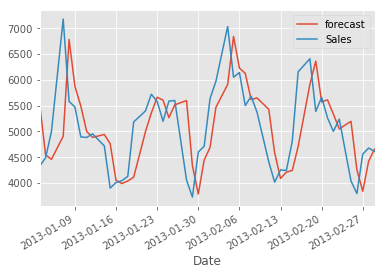

In [17]:
model.plot_predict(1, 50)
plt.show()

This function takes two arguments which are the start and end index of the dataframe to plot. Here, we are plotting the last 50 values.

To plot earlier values, with our predictions extended out, we do the following. This plots true values in 2014, and our predictions 200 days out from 2014.

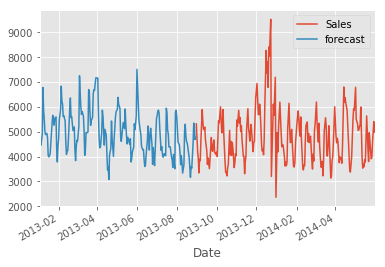

In [18]:
fig, ax = plt.subplots()
ax = store1_sales_data['2013-08-31':'2014-05'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

## Activity: Knowledge Check
We can revisit our diagnostics to check that our models are working well.

1. Plot the residuals and autocorrelation of the residuals.
2. Are there patterns or outliers?

The two previous problems remain:
1. Large errors around the holiday period
2. Errors with high autocorrelation

We can adjust the AR component of the model to account for part of this. Let's increase the lag to 12.

In [19]:
model = ARIMA(store1_sales_data, (12, 1, 2)).fit(solver='ncg')
model.summary()

Optimization terminated successfully.
         Current function value: 7.958767
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 19
         Hessian evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                ARIMA(12, 1, 2)   Log Likelihood               -6207.838
Method:                       css-mle   S.D. of innovations            691.309
Date:                Mon, 10 Jul 2017   AIC                          12447.676
Time:                        16:17:30   BIC                          12522.225
Sample:                    01-03-2013   HQIC                         12476.348
                         - 07-31-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7475      7.523     -0.099      0.921     -15.492      13.997
ar.L1.D.Sales      0.3163      0.168      1.882      0.060      -0.013       0.646
ar.L2.D.Sales     -0.7355      0.174     -4.233      0.000      -1.076      -0.395
ar.L3.D.Sales     -0.4230      0.061     -6.989      0.000      -0.542      -0.304
ar.L4.D.Sales      0.0171      0.063      0.272      0.785      -0.106       0.140
ar.L5.D.Sales     -0.5315      0.081     -6.537      0.000      -0.691      -0.372
ar.L6.D.Sales     -0.0878      0.068     -1.282      0.200      -0.222       0.046
ar.L7.D.Sales     -0.2968      0.070     -4.237      0.000      -0.434      -0.159
ar.L8.D.Sales     -0.3192      0.056     -5.666      0.000      -0.430      -0.209
ar.L9.D.Sales     -0.1956      0.061     -3.189      0.001      -0.316      -0.075
ar.L10.D.Sales    -0.2352      0.060     -3.895      0.000      -0.353      -0.117
ar.L11.D.Sales    -0.0776      0.050     -1.564      0.118      -0.175       0.020
ar.L12.D.Sales    -0.0241      0.070     -0.341      0.733      -0.162       0.114
ma.L1.D.Sales     -0.6210      0.163     -3.803      0.000      -0.941      -0.301
ma.L2.D.Sales      0.7079      0.207      3.413      0.001       0.301       1.115
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9291           -0.5177j            1.0636           -0.0809
AR.2             0.9291           +0.5177j            1.0636            0.0809
AR.3             0.4915           -0.9429j            1.0633           -0.1735
AR.4             0.4915           +0.9429j            1.0633            0.1735
AR.5             0.1214           -1.1731j            1.1793           -0.2336
AR.6             0.1214           +1.1731j            1.1793            0.2336
AR.7            -1.2915           -0.2326j            1.3123           -0.4716
AR.8            -1.2915           +0.2326j            1.3123            0.4716
AR.9            -0.4484           -1.2849j            1.3609           -0.3034
AR.10           -0.4484           +1.2849j            1.3609            0.3034
AR.11           -1.4153           -2.3073j            2.7068           -0.3376
AR.12           -1.4153           +2.3073j            2.7068            0.3376
MA.1             0.4386           -1.1046j            1.1885           -0.1898
MA.2             0.4386           +1.1046j            1.1885            0.1898
------------------------------------------------------------------------------
"""

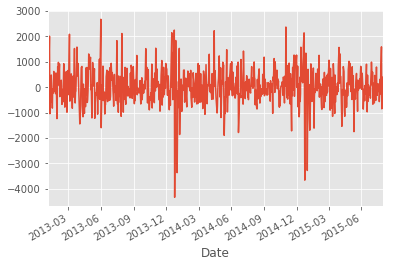

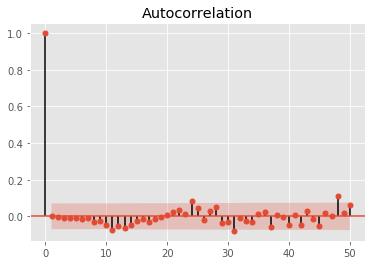

In [20]:
model.resid.plot()
plt.show()
plot_acf(model.resid, lags=50)
plt.show()

This removes some of the autocorrelation in the residuals, but large discrepancies still exist. However, they exist where we are breaking our model assumptions as well, which is important to keep in mind.

## Activity: Knowledge Check
1. Alter the time period of predictions and the p, d, and q parameters.
2. Do any of these improve diagnostics?
3. What does changing p and q imply based upon the autocorrelation plot?
4. How about changing d?

- Increasing p increases the dependency on previous values further (longer lag).  But our autocorrelation plots show this isn’t necessary past a certain point.

- Increasing q increases the likelihood of an unexpected jump at a handful of points.  The autocorrelation plots show this doesn’t help past a certain point.

- Increasing d increases differencing, but d=1 moves our data towards stationarity (other than a few points).  d=2 would imply a faster than linearly changing trend which we don’t have here.

- There are variants of ARIMA that will better handle the seasonal aspect of our data.  This is referred to as Seasonal ARIMA.

- These models fit two ARIMA models, one on the current frequency (daily in our example) and another on the seasonal frequency (maybe monthly or yearly patterns).

- Additionally, issues with seasonality could be handled by preprocessing tricks such as detrending.